# ImageJ to Napari 

This notebooks opens ImageJ, lets the user open an image in ImageJ and transfers the 5D-image to Napari.

Import the jpype stuff, that allows to access java from python and start the java virtual machine.

In [1]:
from jpype import *
# Enable Java imports
import jpype.imports
# Pull in types
from jpype.types import *
import os
os.chdir('/media/baecker/DONNEES1/programs/fiji-linux64/Fiji.app/')
startJVM(getDefaultJVMPath(), 
         "-ea", 
         "-Dpython.cachedir.skip=false", 
         "-Dplugins.dir=.", 
         "-Xmx8000m",
         "-Djava.class.path=./jars/imagej-launcher-5.0.3.jar",
         "-Dimagej.dir=.",
         "-Dij.dir=.",
         "-Dfiji.dir=.",
         "-Dij.executable= ",
        )

For ImageJ1 add the jars in the jars-folder to the classpath.

In [2]:
addClassPath('./jars/*')

This is my trial to use ImageJ2, but it crashes when I try to grab the image. I still need to work on this. So do not run this cell.

In [3]:
# from net.imagej.launcher import ClassLauncher
# ClassLauncher.main(("-ijjarpath", "jars", "-ijjarpath", "plugins", "net.imagej.Main"))

Start ImageJ and display the gui.

In [4]:
import ij
from ij import IJ, ImageJ
ij.ImageJ()
ij1 = IJ.getInstance()
print(ij1)

ij.ImageJ[frame0,756,29,591x112,layout=java.awt.BorderLayout,title=ImageJ,normal]


Open an image in ImageJ before running the next cell.
Get the active image and extract some meta-data from it.

In [5]:
#IJ.open("/media/baecker/DONNEES1/mri/in/spheroids/spheroid01-01.tif")
IJ.run("Mitosis (5D stack)");
# Comment the line above and open an image in ImageJ before executing this cell!
image = IJ.getImage()
cal = image.getCalibration()
zFactor = cal.getZ(1) / cal.getX(1)
title = image.getShortTitle()
shift = 128
bitDepth = image.getBitDepth() 
if bitDepth==16:
    shift = 32768
print(zFactor)

11.299435


Convert the image to a stack, so that it is possible to grab all voxels of all frames in one go.

In [6]:
from ij.plugin import HyperStackConverter
dims = list(image.getDimensions())
print(dims)
isHyperStack = image.isHyperStack()
HyperStackConverter.toStack(image)
stackDims = list(image.getDimensions())

[171, 196, 2, 5, 51]


Grab all voxels and shift the values to compensate for the signed data-types.
Shape the pixels back into the right form according to the dimensions of the hyperstack.
Get each channel as a separate image, because we want to add them as layers to napari.

In [7]:
import numpy as np

pixels = np.array(image.getStack().getVoxels(0,0,0, stackDims[0], stackDims[1], stackDims[3], [])) + shift
pixels = pixels.reshape(dims[4], dims[3], dims[2], dims[1], dims[0])
channels = [0] * dims[2]
for c in range(0, dims[2]):
    channels[c] = pixels[:,:,c,:,:]

If the stack was a hyperstack, transform it back in ImageJ

In [8]:
if isHyperStack:
    image2 = HyperStackConverter.toHyperStack(image, dims[2], dims[3], dims[4], "Composite");
    image.close()
    image2.show()

Display the image in napari.

In [9]:
import napari
viewer = napari.Viewer()
viewer.theme = 'dark'
colors = ['magenta', "cyan", "yellow", "red", "green", "blue"]
for c in range(0, dims[2]):
    viewer.add_image(channels[c],
                     name="C"+str(c+1)+"-"+str(title),
                     colormap=colors[c],
                     blending='additive',
                     scale=[zFactor,1,1])
viewer.dims.ndisplay = 3
viewer.show()

Add the animation-plugin, that allows to create movies from key-frames.

In [10]:
from napari_animation import AnimationWidget

animation_widget = AnimationWidget(viewer)
viewer.window.add_dock_widget(animation_widget, area='right')

Reset napari's gui, in case I messed it up.

In [11]:
from napari.utils.settings import SETTINGS
SETTINGS.reset()

Make a screenshot of the current view in napari and display it with matplotlib.

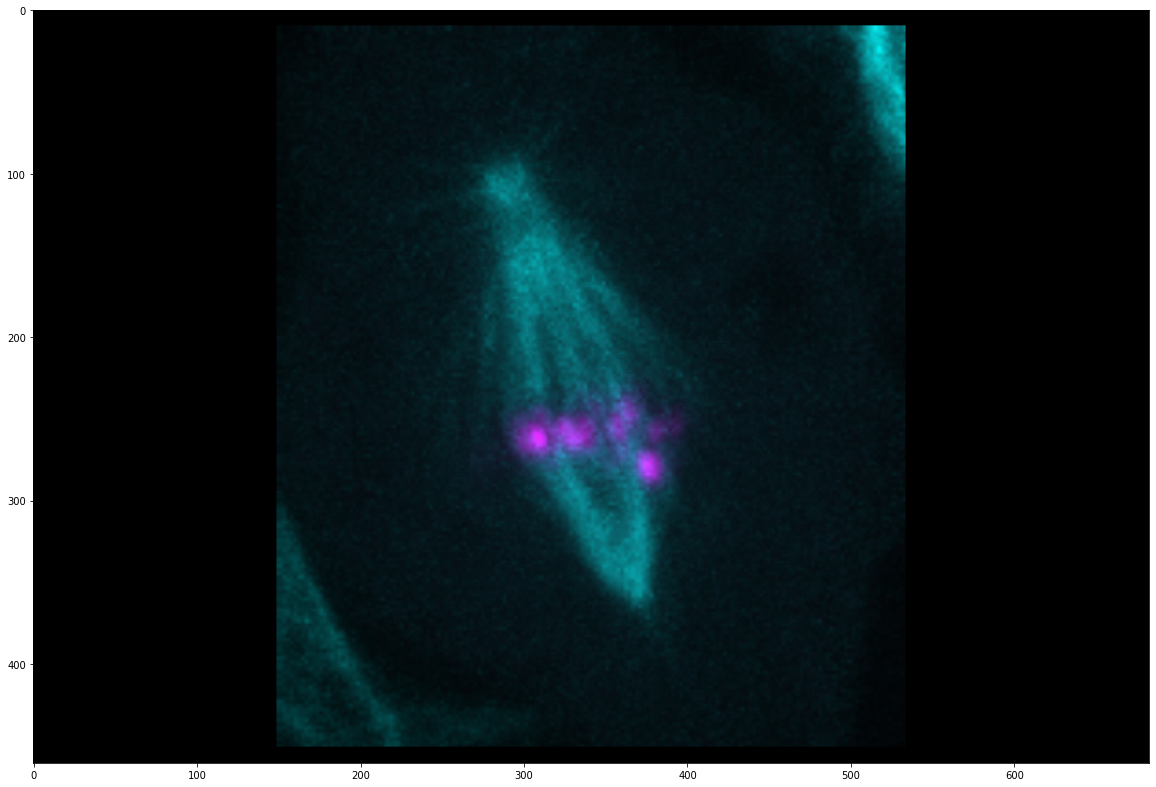

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20,30))
screenshot = viewer.screenshot(canvas_only=True)
plt.imshow(screenshot)

Replace the current image by the active image in ImageJ

In [13]:
for c in range(0, dims[2]):
    viewer.layers.pop(0)
image = IJ.getImage()
cal = image.getCalibration()
zFactor = cal.getZ(1) / cal.getX(1)
title = image.getShortTitle()
dims = list(image.getDimensions())
print(dims)
isHyperStack = image.isHyperStack()
HyperStackConverter.toStack(image)
stackDims = list(image.getDimensions())
pixels = np.array(image.getStack().getVoxels(0,0,0, stackDims[0], stackDims[1], stackDims[3], [])) + shift
pixels = pixels.reshape(dims[4], dims[3], dims[2], dims[1], dims[0])
if isHyperStack:
    image2 = HyperStackConverter.toHyperStack(image, dims[2], dims[3], dims[4], "Composite");
    image.close()
    image2.show()
channels = [0] * dims[2]
for c in range(0, dims[2]):
    channels[c] = pixels[:,:,c,:,:]
for c in range(0, dims[2]):
    viewer.add_image(channels[c],
                     name="C"+str(c+1)+"-"+str(title),
                     colormap=colors[c],
                     blending='additive',
                     scale=[zFactor,1,1])

[171, 196, 2, 5, 51]


# Known problems:

- bioformats not available with IJ1
- 2D+time images not working
- IJ2 crashes when I grab the active image